In [2]:
!pip install tf-nightly-gpu-2.0-preview

    100% |████████████████████████████████| 346.0MB 52kB/s 
    100% |████████████████████████████████| 430kB 10.6MB/s 
    100% |████████████████████████████████| 61kB 29.0MB/s 
    100% |████████████████████████████████| 3.1MB 5.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/89/67/41/63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
Successfully built wrapt
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
  Found existing installation: wrapt 1.10.11
    Uninstalling wrapt-1.10.11:
      Successfully uninstalled wrapt-1.10.11


In [3]:
# Mount the drive in order to get access to the data 
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
# Untar the data we have stored in our drive
!tar -zxf /content/gdrive/My\ Drive/skin_cancer_data/data.tar.gz

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationti

In [0]:
import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import glob
import json
import h5py
import shutil

import numpy as np 
import pandas as pd 
import seaborn as sns
from pathlib import Path
import matplotlib.pylab as pl
import matplotlib.pyplot as plt


from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications import resnet50, mobilenet, mobilenet_v2, vgg16, inception_v3
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Reshape
from tensorflow.keras.layers import Input, Flatten, Activation
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers


color = sns.color_palette()
%matplotlib inline
%config InlineBackend.figure_format="svg"

In [0]:
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

seed=1234

# Set the numpy seed
np.random.seed(seed)

# Set the random seed in tensorflow at graph level
tf.random.set_seed(seed)

In [0]:
# Get the path to train and validation directories
train_data_path = Path("data/train/")
valid_data_path = Path("data/valid/")

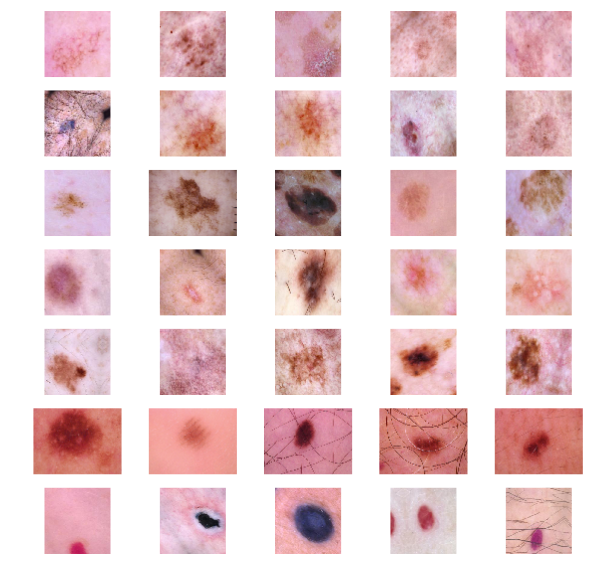

In [9]:
# simple visualization
sample_images = []

# get all subdirs
subdirs = sorted(os.listdir(train_data_path))
subdirs = [x for x in subdirs if "DS_Store" not in x]

# get samples
for subdir in subdirs:
    images = os.listdir(train_data_path / subdir)
    images = [x for x in images if "DS_Store" not in x]
    random_images_idx = np.random.choice(len(images), 5)
    for idx in random_images_idx:
        img = imread(train_data_path/ subdir / images[idx])
        sample_images.append(img)

# plot samples
f,ax = plt.subplots(7, 5, figsize=(10,10))

for i, img in enumerate(sample_images):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis("off")
plt.show()

In [0]:
# some constants
img_height, img_width, img_channels = 224,224,3
batch_size = 64
nb_classes = 7

In [11]:
# Get a generator 
data_gen = ImageDataGenerator(preprocessing_function=mobilenet_v2.preprocess_input)

# Make data generator for training and validation data
train_data_gen = data_gen.flow_from_directory(train_data_path, 
                                              target_size=(img_height, img_width), 
                                              class_mode="categorical", 
                                              shuffle=True, 
                                              batch_size=batch_size)

valid_data_gen = data_gen.flow_from_directory(valid_data_path, 
                                              target_size=(img_height, img_width), 
                                              class_mode="categorical", 
                                              shuffle=False, 
                                              batch_size=batch_size)

Found 32576 images belonging to 7 classes.
Found 850 images belonging to 7 classes.


In [12]:
# prepare validation data 
valid_images, valid_labels = [], []
class_indices = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

subdirs = sorted(os.listdir(valid_data_path))
subdirs = [x for x in subdirs if "DS_Store" not in x]

for subdir in subdirs:
  print(f"Processing {subdir}")
  images = os.listdir(valid_data_path / subdir)
  images = [x for x in images if "DS_Store" not in x]
  print("Number of images found: ", len(images))
  
  for img in images:
    img = imread(valid_data_path / subdir / img)
    img = cv2.resize(img, (img_height, img_width))
    label = class_indices[subdir]
    valid_images.append(img)
    valid_labels.append(label)
  print("="*50)
  
valid_images = np.array(valid_images, dtype=np.float32)
valid_images = mobilenet_v2.preprocess_input(valid_images)
valid_labels = np.array(valid_labels)
valid_labels_cat = to_categorical(valid_labels, num_classes=7)
print("\n", valid_images.shape, valid_labels.shape, valid_labels_cat.shape)

Processing akiec
Number of images found:  34
Processing bcc
Number of images found:  49
Processing bkl
Number of images found:  109
Processing df
Number of images found:  11
Processing mel
Number of images found:  93
Processing nv
Number of images found:  540
Processing vasc
Number of images found:  14

 (850, 224, 224, 3) (850,) (850, 7)


In [0]:
# # compute class weights
# training_labels_count = []

# subdirs = sorted(os.listdir(train_data_path))
# subdirs = [x for x in subdirs if "DS_Store" not in x]

# for subdir in subdirs:
#   print(f"Processing {subdir}")
#   images = os.listdir(train_data_path / subdir)
#   images = [x for x in images if "DS_Store" not in x]
#   print("Number of images found: ", len(images))
#   labels = [class_indices[subdir]]*len(images)
#   training_labels_count +=labels

# training_labels_count = np.array(training_labels_count)
# print(training_labels_count.shape)

# class_weights = compute_class_weight(class_weight="balanced",
#                                      classes=np.unique(training_labels_count), 
#                                      y=training_labels_count)
# class_weights

In [0]:
# Make class weights much simpler
class_weights = {0:1.0, 1:1.0, 2:1.0, 3:3.0, 4: 1.5, 5:1.0, 6:1.0, 7:2.5}

In [0]:
# Get fine-tuning/transfer-learning model
def get_fine_tuning_model(base_model, top_model, inputs, learning_type):
    if learning_type=='transfer_learning':
        print("Doing transfer learning")
        K.set_learning_phase(0)
        base_model.trainable = False
        features = base_model(inputs)
        outputs = top_model(features)
    else:
        print("Doing fine-tuning")
        features = base_model(inputs)
        outputs = top_model(features)
    return Model(inputs, outputs)

In [16]:
# Use MobileNets family models as we have to deploy this on a mobile in the end
base_model = mobilenet_v2.MobileNetV2(input_shape=(img_height, img_width, img_channels),
                                 include_top=False, 
                                 weights='imagenet',
                                 pooling="avg")

9412608/9406464 [==============================] - 1s 0us/step


In [17]:
# Define a top model: extra layers that we are going to add on 
# top of our base network
feature_inputs = Input(shape=base_model.output_shape, name='top_model_input')
x = Reshape((1,1,1280), name='reshape_1')(feature_inputs)
x = Dropout(0.5,name='drop')(x)
x = Conv2D(7, (1,1), name="last_conv", 
           kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Activation(activation="softmax", name="ouputs")(x)
outputs = Reshape((7,), name="reshape_2")(x)

# define the  model
top_model = Model(feature_inputs, outputs, name='top_model')


# get model for tranfser learning
inputs = Input(shape=(img_height, img_width, img_channels))
model = get_fine_tuning_model(base_model, top_model, inputs, "transfer_learning")
model.summary()

Doing transfer learning
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 1280)              2257984   
_________________________________________________________________
top_model (Model)            (None, 7)                 8967      
Total params: 2,266,951
Trainable params: 8,967
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
# We need top 2 predictions in our case
def top_2(y_true, y_pred):
    return top_k_categorical_accuracy(y_true=y_true, y_pred=y_pred, k=2)

In [0]:
# compile the model and check it 
optimizer = Adam(0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['categorical_accuracy', top_2])

In [0]:
# always use earlystopping
# the restore_best_weights parameter load the weights of the best iteration once the training finishes
es = EarlyStopping(patience=5, restore_best_weights=True)

# checkpoint to save model
chkpt = ModelCheckpoint(filepath="gdrive/My Drive/skin_cancer_data/skin_cancer_final.h5", save_best_only=True, save_weights_only=True)

# reduce on plateau
rp = ReduceLROnPlateau(min_lr=1e-5, patience=2, factor=0.5, mode="max", monitor="val_categorical_accuracy")

# number of training and validation steps for training and validation
all_train_images = len(glob.glob("data/train/**/*.jpg"))
all_valid_images = len(glob.glob("data/valid/**/*.jpg"))

nb_train_steps =  all_train_images // batch_size
nb_valid_steps = all_valid_images // batch_size

# number of epochs 
nb_epochs=100
print("Number of training and validation steps: ", nb_train_steps, nb_valid_steps)

Number of training and validation steps:  509 13


In [0]:
# train the model 
history1 = model.fit_generator(train_data_gen, 
                              epochs=nb_epochs, 
                              steps_per_epoch=nb_train_steps, 
                              validation_data=(valid_images, valid_labels_cat),#valid_data_gen,
                              #validation_steps = nb_valid_steps,
                              class_weight = class_weights,
                              callbacks=[es,chkpt, rp])

Epoch 1/100
509/509 [==============================] - 149s 293ms/step - loss: 1.1705 - categorical_accuracy: 0.6393 - top_2: 0.8085 - val_loss: 0.8509 - val_categorical_accuracy: 0.7224 - val_top_2: 0.8630
Epoch 2/100
509/509 [==============================] - 150s 294ms/step - loss: 0.8691 - categorical_accuracy: 0.7292 - top_2: 0.8881 - val_loss: 0.8400 - val_categorical_accuracy: 0.7259 - val_top_2: 0.8725
Epoch 3/100
509/509 [==============================] - 147s 289ms/step - loss: 0.7912 - categorical_accuracy: 0.7565 - top_2: 0.9057 - val_loss: 0.8400 - val_categorical_accuracy: 0.7329 - val_top_2: 0.8725
Epoch 4/100
509/509 [==============================] - 149s 293ms/step - loss: 0.7492 - categorical_accuracy: 0.7729 - top_2: 0.9136 - val_loss: 0.8650 - val_categorical_accuracy: 0.7212 - val_top_2: 0.8674
Epoch 5/100
509/509 [==============================] - 146s 288ms/step - loss: 0.7276 - categorical_accuracy: 0.7810 - top_2: 0.9205 - val_loss: 0.8739 - val_categorical_ac

In [0]:
# unfreeze some layers of base network for fine-tuning
for layer in model.layers[-20:]:
  layer.trainable =True

# compile the model and check it 
optimizer = SGD(0.0001, decay=1e-6, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['categorical_accuracy', top_2])

# checkpoint to save model
chkpt = ModelCheckpoint(filepath="gdrive/My Drive/skin_cancer_data/skin_cancer_final_fine_tuned.h5", save_best_only=True, save_weights_only=True)

In [0]:
# fine-tune our current model
history2 = model.fit_generator(train_data_gen, 
                              epochs=nb_epochs, 
                              steps_per_epoch=nb_train_steps, 
                              validation_data=valid_data_gen,
                              validation_steps = nb_valid_steps, 
                              callbacks=[es,chkpt, rp])

Epoch 1/100
509/509 [==============================] - 322s 632ms/step - loss: 0.6471 - categorical_accuracy: 0.7653 - top_2: 0.9074 - val_loss: 0.7023 - val_categorical_accuracy: 0.7644 - val_top_2: 0.8942
Epoch 2/100
509/509 [==============================] - 307s 603ms/step - loss: 0.5856 - categorical_accuracy: 0.7905 - top_2: 0.9232 - val_loss: 0.7282 - val_categorical_accuracy: 0.7560 - val_top_2: 0.9002
Epoch 3/100
509/509 [==============================] - 308s 606ms/step - loss: 0.5486 - categorical_accuracy: 0.8056 - top_2: 0.9329 - val_loss: 0.6824 - val_categorical_accuracy: 0.7584 - val_top_2: 0.8894
Epoch 4/100
509/509 [==============================] - 308s 605ms/step - loss: 0.4931 - categorical_accuracy: 0.8273 - top_2: 0.9446 - val_loss: 0.6771 - val_categorical_accuracy: 0.7644 - val_top_2: 0.9026
Epoch 5/100
509/509 [==============================] - 306s 602ms/step - loss: 0.4802 - categorical_accuracy: 0.8341 - top_2: 0.9472 - val_loss: 0.6789 - val_categorical_ac

In [0]:
# load best weights
model.load_weights("gdrive/My Drive/skin_cancer_data/skin_cancer_final_fine_tuned.h5")

# Make predictions on the validation set
preds = model.predict(valid_images)
preds = np.argmax(preds, axis=-1)

[[ 17   7   6   0   2   2   0]
 [  2  39   3   1   1   3   0]
 [  9   4  49   1  10  36   0]
 [  2   1   0   2   0   6   0]
 [  6   4  11   0  42  30   0]
 [  3   7   8   2  15 505   0]
 [  0   1   2   0   0   3   8]]


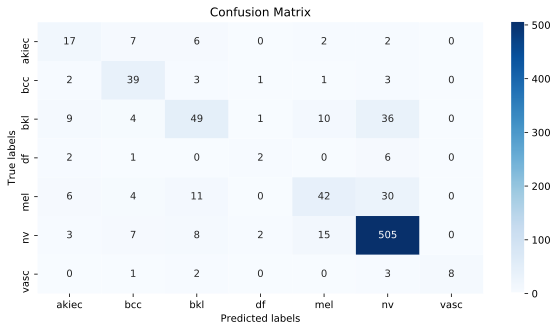

In [39]:
# Get the confusion matrix
cm = confusion_matrix(y_true=valid_labels, y_pred=preds)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(10,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt=".0f")

# labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

# ticks
ax.xaxis.set_ticklabels(list(class_indices.keys()))
ax.yaxis.set_ticklabels(list(class_indices.keys()))
plt.show()

In [40]:
# Generate a classification report
cancer_report = classification_report(valid_labels, preds, target_names=list(class_indices.keys()))
print(cancer_report)

              precision    recall  f1-score   support

       akiec       0.44      0.50      0.47        34
         bcc       0.62      0.80      0.70        49
         bkl       0.62      0.45      0.52       109
          df       0.33      0.18      0.24        11
         mel       0.60      0.45      0.52        93
          nv       0.86      0.94      0.90       540
        vasc       1.00      0.57      0.73        14

   micro avg       0.78      0.78      0.78       850
   macro avg       0.64      0.56      0.58       850
weighted avg       0.77      0.78      0.77       850



In [0]:
# save the model for future use
model.save("gdrive/My Drive/skin_cancer_data/skin_cancer_best_model.h5")

In [0]:
# save the architecture as well for future use 
json_string = model.to_json()

f = open("gdrive/My Drive/skin_cancer_data/skin_cancer_best_model_arch.json", "w")
json.dump(json_string, f)
f.close()